In [1]:
### Install Libraries
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers
!pip install -q opencv-python

In [2]:
### Import libraries
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image

from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

from numpy import asarray

c:\Users\admin\miniconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
### Import Clip and ClipSeg repositories

# Install Clip from OpenAI ## MIT Licence
!pip install -q git+https://github.com/openai/CLIP.git

# Install ClipSeg Repo ## MIT Licence
!git clone https://github.com/timojl/clipseg  S

fatal: destination path 'S' already exists and is not an empty directory.


In [4]:
import sys
print(sys.version)

3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:29:11) [MSC v.1935 64 bit (AMD64)]


In [8]:
# Important: Move into the ClipSeg folder
%cd C:/Users/admin/Desktop/seg inpainting/S

C:\Users\admin\Desktop\seg inpainting\S


In [9]:
### Get the weights for the ClipSeg model
### These weights don't have MIT licence, they can only be used for research, not for commercial purposes
! wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
! unzip -d weights -j weights.zip

--2024-03-02 19:05:17--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de... 134.76.23.45
Connecting to owncloud.gwdg.de|134.76.23.45|:443... connected.
OpenSSL: error:1407742E:SSL routines:SSL23_GET_SERVER_HELLO:tlsv1 alert protocol version
Unable to establish SSL connection.
'unzip'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [12]:
# Import Clip and ClipSeg model
import clip
from models.clipseg import CLIPDensePredT

# load clipseg model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();

# non-strict mode: decoder weights only (no CLIP weights)
model.load_state_dict(torch.load('C:/Users/admin/Desktop/seg inpainting/clipseg_weights/clipseg_weights/rd64-uni.pth', map_location=torch.device('cpu')), strict=False);

In [24]:
### Import Stable Diffusion model
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir="stabilityai/stable-diffusion-2-inpainting"

### The scheduler determine the algorithm used to produce new samples during the denoising process
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir,
                                                   scheduler=scheduler,
                                                   revision="fp16",
                                                   torch_dtype=torch.float32)
pipe = pipe.to("cpu")
# pipe.enable_xformers_memory_efficient_attention()

### if you receive a triton error message, that's normal on windows systems

c:\Users\admin\miniconda3\Lib\site-packages\diffusers\pipelines\pipeline_utils.py:263: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\admin\miniconda3\Lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Source image size: (854, 854)
Target image size: (512, 512)


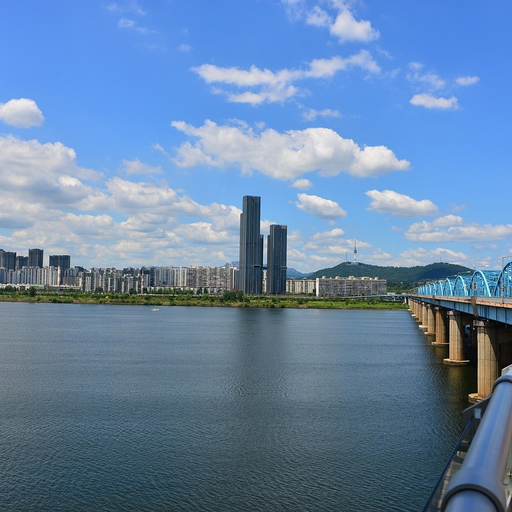

In [25]:
from PIL import Image

target_width, target_height = 512, 512
source_image = Image.open('C:/Users/admin/Desktop/test/han river1.jpg').convert('RGB')

width, height = source_image.size
print(f"Source image size: {source_image.size}")

source_image = source_image.crop((0, height - width, width, height))
source_image = source_image.resize((target_width, target_height), Image.LANCZOS)
print(f"Target image size: {source_image.size}")

### Setup transformations to be applied to the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

tensor_image = transform(source_image).unsqueeze(0)

display(source_image)

In [26]:
#### Create masks for the parts

prompts = ['house', 'ground', 'sky', 'water']

# Use ClipSeg to identify elements in picture
with torch.no_grad():
    preds = model(tensor_image.repeat(len(prompts),1,1,1), prompts)[0]

In [27]:
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()

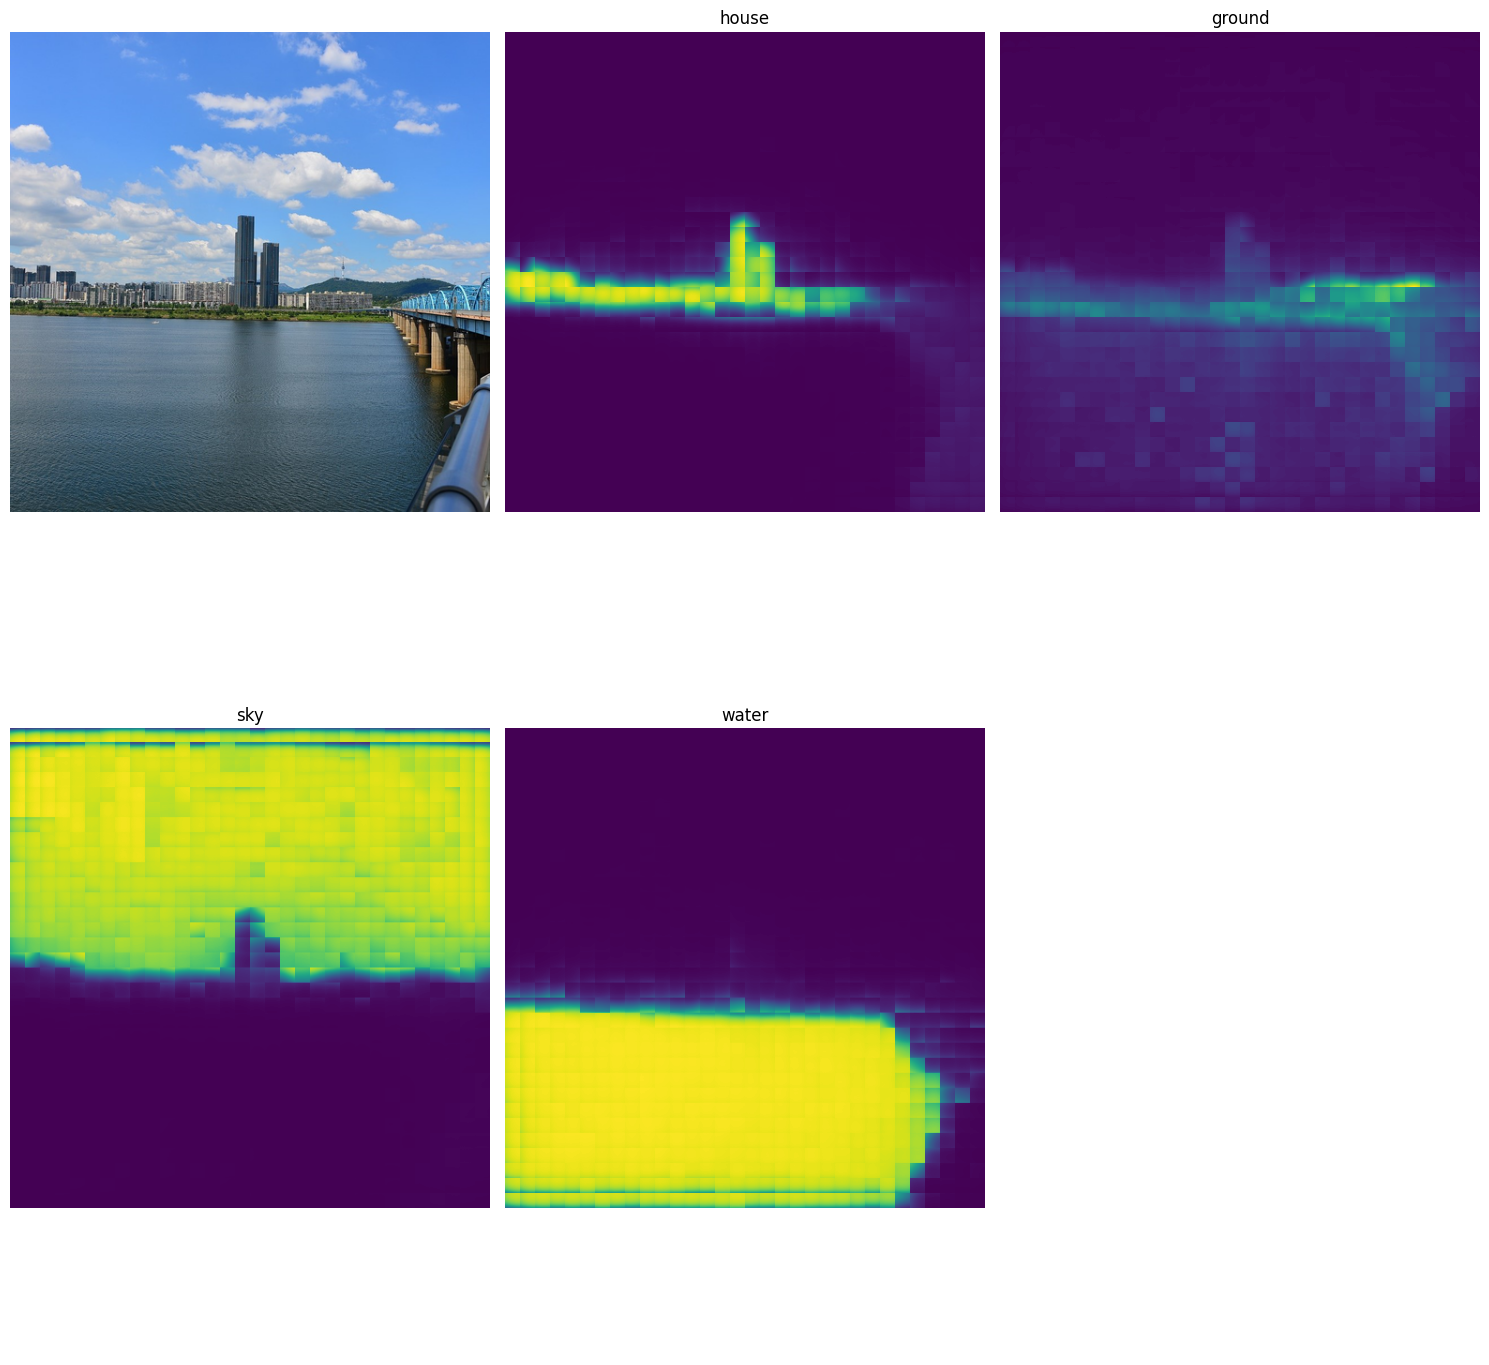

In [28]:
create_image_grid(source_image, preds, prompts, 2, 3)

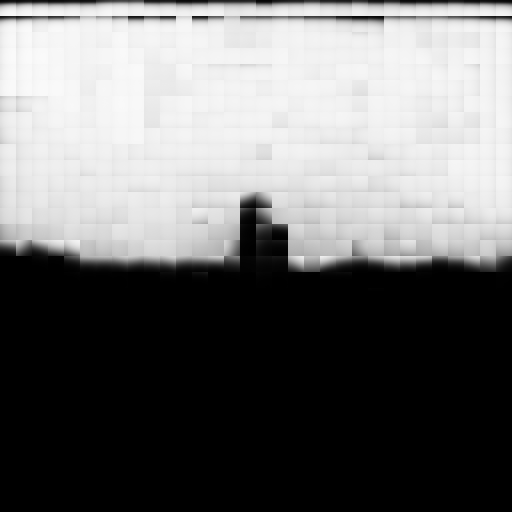

In [29]:
# 기존 코드 (얘는 그냥 무조건 실행)
# Decide which mask you want to do inpainting with. In this case we pick the skirt which is mask number 1

mask_number = 2

# Normalize mask values by computing the area under Gaussan probability density function, calculating the cumulative distribution with ndtr
processed_mask = torch.special.ndtr(preds[mask_number][0])

stable_diffusion_mask = transforms.ToPILImage()(processed_mask)
display(stable_diffusion_mask)


In [ ]:
# # 영역 확장 코드
# # Normalize mask values by computing the area under Gaussan probability density function, calculating the cumulative distribution with ndtr
# processed_mask = torch.special.ndtr(preds[mask_number][0])

# # 확장된 영역을 위해 마스크 영역 확장
# # kernel_size를 늘릴 경우 확장이 더 많이 되고, padding값이 커질 수록 확장된 영역이 넓어진다.
# expanded_mask = processed_mask.clone()
# expanded_mask = torch.nn.functional.max_pool2d(expanded_mask.unsqueeze(0).unsqueeze(0), kernel_size=5, stride=1, padding=0).squeeze()

# # 마스크 정규화
# expanded_mask = (expanded_mask - expanded_mask.min()) / (expanded_mask.max() - expanded_mask.min())

# stable_diffusion_mask = transforms.ToPILImage()(expanded_mask)
# display(stable_diffusion_mask)

In [30]:
# 기존 코드
### Setup transformation prompts

num_images_per_prompt = 4
inpainting_prompts = ["cloudy sky",  "dark sky with full cloud", "dark and unclear sky", "dark, black sky"]

generator = torch.Generator(device="cpu").manual_seed(77) # 155, 77,

### Run Stable Difussion pipeline in inpainting mode
encoded_images = []
for i in range(num_images_per_prompt):
        image = pipe(prompt=inpainting_prompts[i], guidance_scale=7.5, num_inference_steps=60, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
        encoded_images.append(image)
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)

  0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Run Stable Difussion pipeline in inpainting mode for the first prompt
image = pipe(prompt=inpainting_prompts[0], guidance_scale=7.5, num_inference_steps=60, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]

# Display the resulting image
print(f"Result for prompt '{inpainting_prompts[0]}':")
display(to_pil_image(torch.sigmoid(image)))
